# Assignment Goals

#### 1. Define Economic Regimes
I will define economic regimes by looking at growth and inflation trends. I am thinking of expressing it using state vectors. I will probably use flags to search through the data.

#### 2. Find Optimal Hedge for S&P 500 using Gold & Treasuries for each Regime
I am not sure how to interpret this objective. I think the goal is to create an optimal portfolio using the 4 assets to hedge the S&P 500 during the different economic regimes. I will expound more on this below when I reach this part.

## 1. Define Economic Regimes
I will first load the dataset and store the different sheets separately.

In [78]:
import pandas as pd
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
import seaborn as sns

### Importing Dataset

In [79]:
macro = pd.read_excel('Data_190324.xlsx',sheet_name=0)
prices = pd.read_excel('Data_190324.xlsx',sheet_name=1)
yld = pd.read_excel('Data_190324.xlsx',sheet_name=2)
macro.head()

,Date,GDP YOY,CPI YOY
0,1970-12-31,-0.2,5.6
1,1971-01-31,NaN,5.3
2,1971-02-28,NaN,5.0
3,1971-03-31,2.7,4.7
4,1971-04-30,NaN,4.2


In [80]:
macro['GDP YOY']

0     -0.2
1      NaN
2      NaN
3      2.7
4      NaN
      ... 
634    NaN
635    NaN
636    3.1
637    NaN
638    NaN
Name: GDP YOY, Length: 639, dtype: float64

In [81]:
macro['GDP YOY'][2]

nan

### Preliminary Data Viz

I am going to see how the gdp yoy var moves across quarterly yoy and we can see below that apparently there is some implicit interpolation. 

In [82]:
#for i in range(len(macro)):
   # if macro['GDP YOY']


Macros = pd.DataFrame(columns=['Date', 'GDP YOY'])
for i in range(0,len(macro),3):
    Macros.loc[i] = [macro['Date'][i], macro['GDP YOY'][i]]
Macros.reset_index(drop=True, inplace=True)
#Macros

Text(0.5, 0, 'Year')

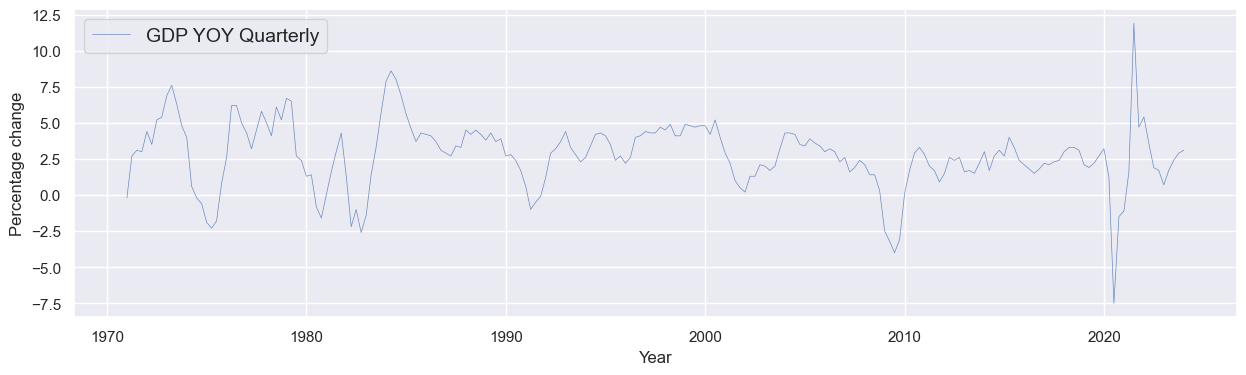

In [83]:
plt.figure(figsize=(15,4))
plt.plot(Macros['Date'], Macros['GDP YOY'],lw=0.5,alpha=0.8,label='GDP YOY Quarterly')
plt.legend(loc='upper left', fontsize=14)
#plt.title('Prices over time')
plt.ylabel('Percentage change')
plt.xlabel('Year')


In [84]:
neg=0
pos=0

for i in range(len(Macros)):
    if Macros['GDP YOY'][i]<0:
        neg+=1
    else:
        #i could do n=213 - neg = pos, but doing this just to stay safe
        #if the numbers dont add up, that will alert me to any inconsistency
        pos+=1


print("For a total of {} periods, there were {} periods of positive YoY growth and {} periods of negative growth. We can also see that the data is consistent since pos + neg = {} = len(macro)".format(len(Macros),pos,neg,pos+neg))


For a total of 213 periods, there were 191 periods of positive YoY growth and 22 periods of negative growth. We can also see that the data is consistent since pos + neg = 213 = len(macro)


I will thus explicitly define the interpolation

Text(0.5, 0, 'Year')

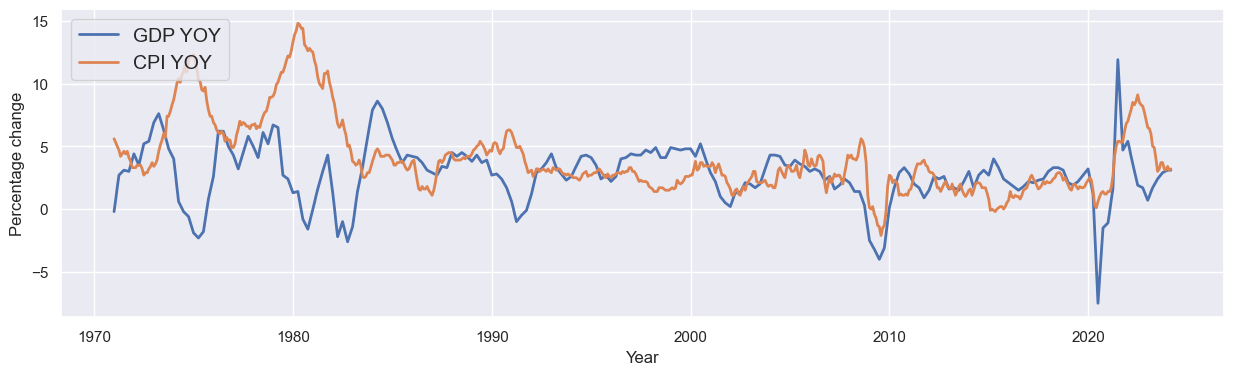

In [85]:
plt.figure(figsize=(15,4))
macro['GDP YOY']=macro['GDP YOY'].interpolate()
#this is a pretty good function! the plots for interpolated monthly and non-interpolated quarterly look the same
col=['GDP YOY','CPI YOY']
for i in range(len(col)):
    plt.plot(macro['Date'], macro[col[i]],lw=2,alpha=1,label=col[i])
#plt.plot(prices['Date'], prices[col[1]],lw=0.5,alpha=0.8,label=col[1])
plt.legend(loc='upper left', fontsize=14)
#plt.title('Prices over time')
plt.ylabel('Percentage change')
plt.xlabel('Year')


### Assumption 1: Growth & Inflation Trends

Here I will assume that due to the fluctuations in a business cycle, it will be more relevant to understand growth and inflation by utilizing YoY data for GDP and inflation (through CPI).

This can help identify signals within the noise as opposed to only using consecutive GDP and CPI rates. The idea is to rule out seasonal trends to allow for better [examination](https://www.investopedia.com/terms/y/year-over-year.asp) of trends.

I will try to do some EDA to develop a rough sense of periods of growth

In [86]:
#set accum var
neg=0
pos=0
for i in range(len(macro)):
    if macro['GDP YOY'][i]<0:
        neg+=1
    else:
        #i could do n=213 - neg = pos, but doing this just to stay safe
        #if the numbers dont add up, that will alert me to any inconsistency
        pos+=1


print("For a total of {} periods, there were {} periods of positive YoY growth and {} periods of negative growth. We can also see that the data is consistent since pos + neg = {} = len(macro)".format(len(macro),pos,neg,pos+neg))



For a total of 639 periods, there were 572 periods of positive YoY growth and 67 periods of negative growth. We can also see that the data is consistent since pos + neg = 639 = len(macro)


What we found above is important because it will help us determine the economic regime. Given the prevalence of positive growth, I will further split it to see if it's low, normal or high growth.


In [87]:
low=0
nor=0
high=0
for i in range(len(macro)):
    if macro['GDP YOY'][i]<2:
        low+=1
    elif macro['GDP YOY'][i]<3:
        nor+=1
    else:
        high+=1


print("For a total of {} periods, there were {} periods of low growth, {} periods of normal growth and {} periods of high growth. We can also see that the data is consistent since low + nor + high = {} = len(gdp)".format(len(macro),low,nor,high,low+nor+high))


For a total of 639 periods, there were 186 periods of low growth, 144 periods of normal growth and 309 periods of high growth. We can also see that the data is consistent since low + nor + high = 639 = len(gdp)


### Observation

The above classification groups negative growth and <2% growth together. I am mainly doing this so it's easier to make generalizations. I am also defining normal growth as between [2-3%](https://corporatefinanceinstitute.com/resources/economics/economic-growth-rate/#:~:text=For%20a%20developed%20economy%2C%20an,economy%20is%20expanding%20and%20prospering.). And, high growth will be defined as >3%.

This allows us to broadly understand the growth trends where we see that the past 50 years has been dominated by periods of high and normal growth. But, a sizeable chunk of it has been low growth. There are several ways to understand this and I will revisit this soon.


### Exposition into inflation

Generally, it is accepted that the normal/ideal inflation rate is between [2-3%](https://www.investopedia.com/ask/answers/111414/what-difference-between-inflation-and-deflation.asp#:~:text=borrowing%2C%20and%20spending.-,The%20Bottom%20Line,in%20excess%20of%20wage%20increases.). And high inflation is considered to be greater than [5%](https://www.investopedia.com/terms/h/hyperinflation.asp#:~:text=Hyperinflation%20is%20a%20scenario%20in,5%25%20is%20considered%20high%20inflation.).

I will modify this to make normal inflation between 2-4% and high inflation >4%. I am doing this mainly because of simplicity and I understand this isn't perfect but one step at a time.

In [88]:
#inf=[]
#macro


#for i in range(0,639):
 #   inf.append(macro['CPI YOY'][i])

#len(inf)
#convert inf into an nx1 vector
#this will make it easier to track cpi yoy movements and iteratively improve on my model
#inf=np.array(inf).reshape(639,1)
#inf
def inflation_checker(l,n):
    low = 0
    nor = 0
    high = 0
    for i in range(len(macro)):
        if macro['CPI YOY'][i]<l:
            low+=1
        elif macro['CPI YOY'][i]<n:
            nor+=1
        else:
            high+=1
    return low, nor, high

low1, nor1, high1 = inflation_checker(2,4)
print("For a total of {} periods, there were {} periods of low inflation, {} periods of normal inflation and {} periods of high inflation.".format(len(macro),low1,nor1,high1))
print("We can verify consistency since low + nor + high = {}".format(low1+nor1+high1))
#inflation_checker(2,3)
print("{} periods of deflation".format(inflation_checker(0,2)[0]))


For a total of 639 periods, there were 138 periods of low inflation, 277 periods of normal inflation and 224 periods of high inflation.
We can verify consistency since low + nor + high = 639
11 periods of deflation


### Observation
The data shows that most monthly YoY inflation rates were within 2-4% for 277 months followed by 224 months of high inflation (>4%) and 138 months of low inflation (<2%)

A few pointers,
1. I am clumping low inflation and deflation together since deflation (<0%) only has 11 occurrences.
1. Yes, if we strictly stick to normal inflation as 2-3%, then high inflation will be dominating but visually there is alot of variance within high inflation so I believe it is justified to isolate higher inflation. An even better approach would be to further segment high inflation so I can better study possible interaction effects.

These preliminary explorations gives us a feel of the macroeconomic landscape over the past 50 years. 

Now, using the above parameters, I will define the economic regimes.
1. Low Inflation & Low Growth **LL**
2. Low Inflation & Normal Growth **LN**
3. Low Inflation & High Growth **LH**
4. Normal Inflation & Low Growth **NL**
2. Normal Inflation & Normal Growth **NN**
3. Normal Inflation & High Growth **NH**
4. High Inflation & Low Growth **HL**
2. High Inflation & Normal Growth **HN**
3. High Inflation & High Growth **HH**



In [89]:
#regime_classification = np.zeros(639)
#macro['regime'] = regime_classification
LL_count = 0
LN_count = 0
LH_count = 0
NL_count = 0
NN_count = 0
NH_count = 0
HL_count = 0
HN_count = 0
HH_count = 0
Undef_count = 0

macro
regime_classifications=[]
# Iterate through each observation in the DataFrame
for i in range(len(macro)):
    inflation = macro['CPI YOY'][i]
    growth = macro['GDP YOY'][i]
    
    # Classify the observation into regimes based on inflation and growth
    if inflation < 2 and growth < 2:
        regime_classifications.append('LL')
        LL_count+=1
    elif inflation < 2 and 2 <= growth < 3:
        regime_classifications.append('LN')
        LN_count+=1
    elif inflation < 2 and growth >= 3:
        regime_classifications.append('LH')
        LH_count+=1
    elif 2 <= inflation < 4 and growth < 2:
        regime_classifications.append('NL')
        NL_count+=1
    elif 2 <= inflation < 4 and 2 <= growth < 3:
        regime_classifications.append('NN')
        NN_count+=1
    elif 2 <= inflation < 4 and growth >= 3:
        regime_classifications.append('NH')
        NH_count+=1
    elif inflation >= 4 and growth < 2:
        regime_classifications.append('HL')
        HL_count+=1
    elif inflation >= 4 and 2 <= growth < 3:
        regime_classifications.append('HN')
        HN_count+=1
    elif inflation >= 4 and growth >= 3:
        regime_classifications.append('HH')
        HH_count+=1
    else:
        regime_classifications.append('Undefined')  # Handle any undefined cases
        Undef_count+=1

# Append the regime classifications to a new column in the DataFrame
macro['regime'] = regime_classifications 

# Print the updated DataFrame with the regime classification
#print(df)
macro
print("LL {}, LN {}, LH {}, NL {}, NN {}, NH {}, HL {}, HN {},HH {}".format(LL_count,LN_count,LH_count,NL_count,NN_count,NH_count,HL_count,HN_count,HH_count))
                                                                            

LL 55, LN 41, LH 42, NL 47, NN 76, NH 154, HL 84, HN 27,HH 113


## Important Note

The above results might look concerning due to possible over-fitting and with increased fragmentation, regimes like HN<30 can have difficulties finding variance, etc. 

I don't need to worry about this because the current regime variable is unique to each year and month. Later, I am going to take this data and map it to the daily data of the prices sheet. There, I will quite easily achieve asymptotic properties since there is 1000s of observations. 

Here, a brief theoretical digression is needed. I don't even need to map the monthly level data to the daily level to achieve asymptotic property. Because, it is the same as bootstrapping the current monthly level data to approximate the variance of the true distribution.

Back to reality, let me address the concerns of possible over-fitting. In theory, yes, that is a problem. However, my goal is to understand how the prices of different assets comoves with each other. This is because we are trying to understand the confluence of growth and inflation on the relationship between the assets.

## Constructing Markov Chains

I am quickly constructing a markov chain from the data to have an understanding of how the different states transit to each other and by finding the stationary distribution, to understand on average where we would expect the economy to be given the past 50 years of data.

In [90]:
#step1: specify the index and column so we know which element to sum up the instances
transition_matrix = pd.DataFrame(0, index=['LL','LN','LH','NL','NN','NH','HL','HN','HH'], columns=['LL','LN','LH','NL','NN','NH','HL','HN','HH'])

#step2: run loop and sum up instances of starting from one state and going to another
for i in range(len(macro)-1):
    current_category = macro.loc[i, 'regime']
    next_category = macro.loc[i+1, 'regime']
    transition_matrix.loc[current_category, next_category] += 1
    #pandas data frame allows us to effectively treat it as a matrix!!
#step3: convert instances count to probabilities
transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)
print("Transition Matrix")
print(transition_matrix)
P=np.array(transition_matrix)
print("Stationary distribution:")
print(qe.MarkovChain(P).stationary_distributions)


Transition Matrix
          LL        LN        LH        NL        NN        NH        HL  \
LL  0.836364  0.054545  0.000000  0.072727  0.036364  0.000000  0.000000   
LN  0.073171  0.634146  0.097561  0.000000  0.170732  0.024390  0.000000   
LH  0.000000  0.119048  0.833333  0.000000  0.000000  0.047619  0.000000   
NL  0.106383  0.000000  0.000000  0.723404  0.127660  0.000000  0.021277   
NN  0.013158  0.092105  0.000000  0.065789  0.710526  0.105263  0.000000   
NH  0.000000  0.000000  0.019608  0.000000  0.032680  0.901961  0.000000   
HL  0.000000  0.000000  0.000000  0.047619  0.000000  0.000000  0.904762   
HN  0.000000  0.000000  0.000000  0.000000  0.074074  0.000000  0.222222   
HH  0.000000  0.000000  0.000000  0.000000  0.000000  0.044248  0.000000   

          HN        HH  
LL  0.000000  0.000000  
LN  0.000000  0.000000  
LH  0.000000  0.000000  
NL  0.000000  0.021277  
NN  0.013158  0.000000  
NH  0.000000  0.045752  
HL  0.047619  0.000000  
HN  0.592593  0.11111

## 2. Finding Optimal Hedge 

First, I need to do some EDA on prices and yld


My goal is to create an overall optimal portfolio and [hedge](https://www.investopedia.com/trading/hedging-beginners-guide/#:~:text=Hedging%20is%20a%20risk%20management,provides%2C%20known%20as%20the%20premium.) the optimal portfolio in different regimes.


In [91]:
prices

,Date,S&P 500,Gold,USD Index Spot Rate
0,1970-12-31,92.15,37.44,120.643
1,1971-01-04,91.15,NaN,120.530
2,1971-01-05,91.80,NaN,120.520
3,1971-01-06,92.35,NaN,120.490
4,1971-01-07,92.38,NaN,120.550
...,...,...,...,...
13780,2024-03-13,5165.31,2174.41,102.789
13781,2024-03-14,5150.48,2162.19,103.360
13782,2024-03-15,5117.09,2155.90,103.432
13783,2024-03-18,5149.42,2160.36,103.579


There's data recorded daily from 1970 and it seems there's some missing data

In [92]:
prices['Gold']=prices['Gold'].interpolate()

In [93]:
prices

,Date,S&P 500,Gold,USD Index Spot Rate
0,1970-12-31,92.15,37.4400,120.643
1,1971-01-04,91.15,37.4615,120.530
2,1971-01-05,91.80,37.4830,120.520
3,1971-01-06,92.35,37.5045,120.490
4,1971-01-07,92.38,37.5260,120.550
...,...,...,...,...
13780,2024-03-13,5165.31,2174.4100,102.789
13781,2024-03-14,5150.48,2162.1900,103.360
13782,2024-03-15,5117.09,2155.9000,103.432
13783,2024-03-18,5149.42,2160.3600,103.579


In [94]:
prices.count()

Date                   13785
S&P 500                13421
Gold                   13785
USD Index Spot Rate    13610
dtype: int64

In [95]:
yld

,Date,US 10YR Bonds
0,1970-12-31,6.5020
1,1971-01-04,6.4620
2,1971-01-05,6.4720
3,1971-01-06,6.4720
4,1971-01-07,6.4520
...,...,...
13631,2024-03-13,4.1899
13632,2024-03-14,4.2903
13633,2024-03-15,4.3063
13634,2024-03-18,4.3242


Plotting USD Index Spot Rate..

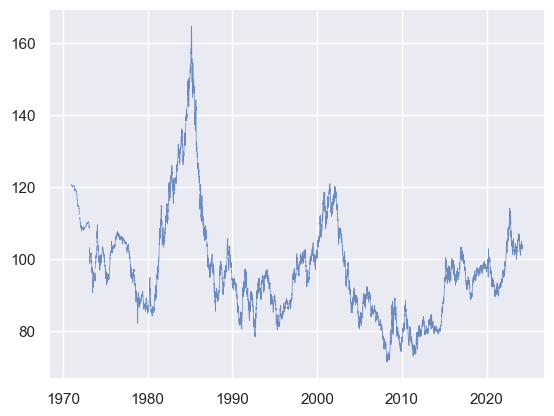

In [96]:
#print(yld.head())
#print(yld.count())
#print(prices.head())
#print(prices.count())
#yld.count()
col=['S&P 500','Gold','USD Index Spot Rate']
plt.plot(prices['Date'],prices[col[2]],lw=0.5,alpha=0.8,label=col[2])

### Data viz

I want to see how the prices have moved across time.

Text(0.5, 0, 'Year')

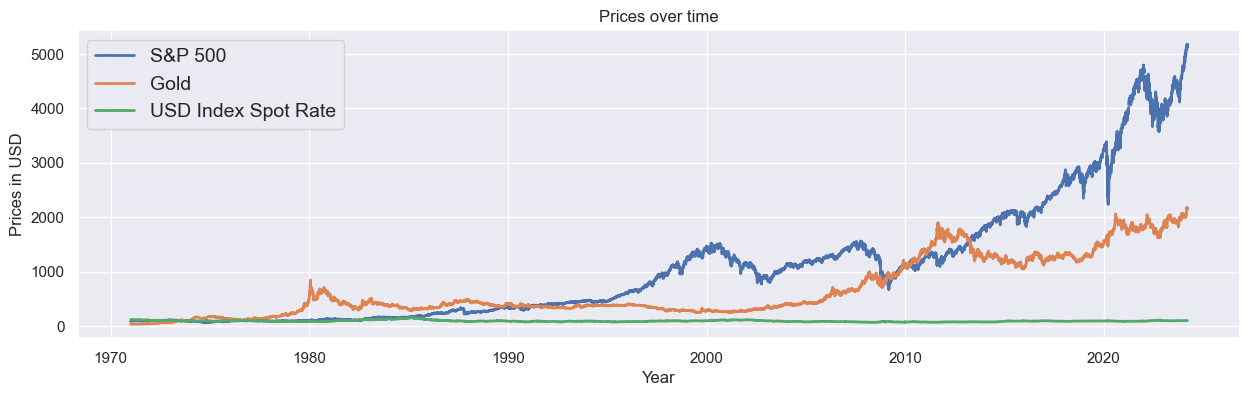

In [97]:
plt.figure(figsize=(15,4))
# Convert 'date' column to datetime object
#prices['Date'] = pd.to_datetime(prices['Date'])
#col=['S&P 500','Gold','USD Index Spot Rate']
for i in range(3):
    plt.plot(prices['Date'], prices[col[i]],lw=2,alpha=1,label=col[i])
#plt.plot(prices['Date'], prices[col[1]],lw=0.5,alpha=0.8,label=col[1])
plt.legend(loc='upper left', fontsize=14)
plt.title('Prices over time')
plt.ylabel('Prices in USD')
plt.xlabel('Year')


Now, I am going to plot the daily returns for these assets across time and over here I will not separate them based on their regimes.

/var/folders/y5/98bzpjp15s1gwld_6_9j2hy00000gn/T/ipykernel_1146/1488559114.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns[col[i]]=prices[col[i]].pct_change()


Text(0.5, 0, 'Year')

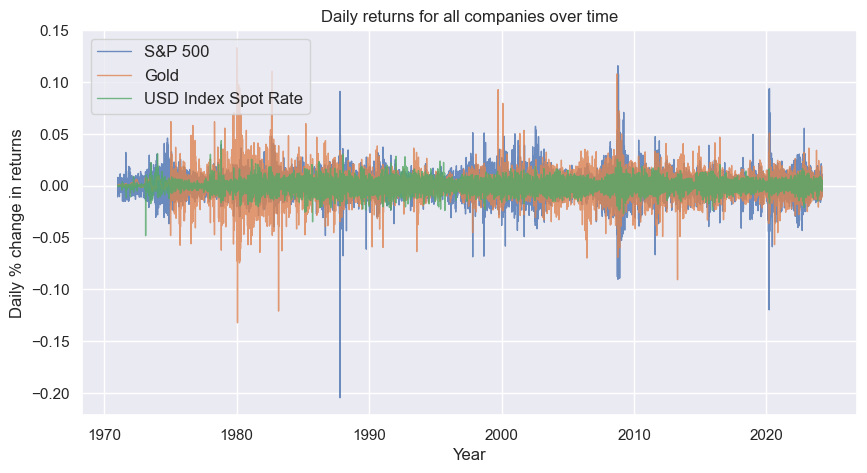

In [98]:
returns = pd.DataFrame(columns=['S&P 500', 'Gold','USD Index Spot Rate'])
#returns['Date']=prices['Date']
#returns
for i in range(3):     
    returns[col[i]]=prices[col[i]].pct_change()
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.plot(prices['Date'], returns[col[i]], lw=1, alpha=0.8,label=col[i])
plt.legend(loc='upper left', fontsize=12)
plt.title('Daily returns for all companies over time')
plt.ylabel('Daily % change in returns')
plt.xlabel('Year')

We can see gold and S&P are quite volatile and it seems S&P has higher volatility.

Now, I am going to plot the correlation matrix without considering the different regimes.

This is important to give me a preliminary gauge of how my overall optimal portfolio will be constructed.

,S&P 500,Gold,USD Index Spot Rate
S&P 500,1.000000,-0.008217,-0.026313
Gold,-0.008217,1.000000,-0.310369
USD Index Spot Rate,-0.026313,-0.310369,1.000000


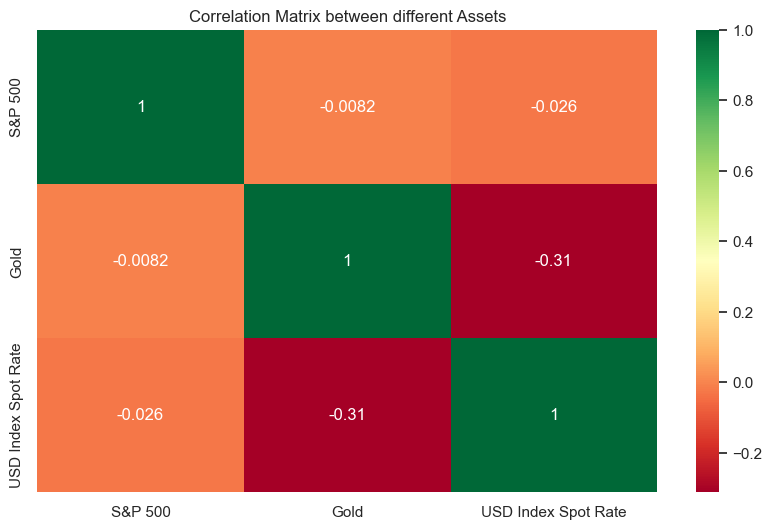

In [99]:
plt.figure(figsize=(10, 6))
plt.title('Correlation Matrix between different Assets')
sns.set(style='darkgrid')
corr = returns.corr()
sns.heatmap(corr,annot=True,cmap='RdYlGn')

corr

Honestly, this seems concerning. I was hoping to find a reasonable negative correlation between S&P and the other assets. Hopefully, when I look at each regime, the negative correlation will be more significant. 

I want negative correlation because when I construct my optimal portfolio to hedge my returns, I will need assets that comove differently. That way, if the market negatively affects one asset, the other assets can be predicted to increase in returns.

And with the above results, I simply cannot construct an overall optimal portfolio with all these assets. So, instead I will create an overall optimal portfolio simply consisting of S&P 500 and for each regime, I will create its respective optimal portfolio using the different assets. I am hoping to see strong negative correlations in the different regimes so I can effectively hedge the S&P asset.

Before I do all that, I want to quickly explore the 10yr bond yields and see if I can incorporate it into my portfolio.

## Important Note

From my understanding, the optimal portfolio is a weighted average of the basket of risky assets and the risk-free asset. Due to my time constraints, I was unable to figure out the risk-free rate. Initially, I thought of using the 10 year rates but given how the yields fluctuate, I was unsure of how to derive the risk-free rate. 

Because of this, unfortunately, I will be unable to construct an optimal portfolio that considers the above definition. Instead, I will try to explore the minimum variance portfolio where I will try to compare bond yields and the prices of the different assets.

#### Some data viz

Text(0.5, 0, 'Year')

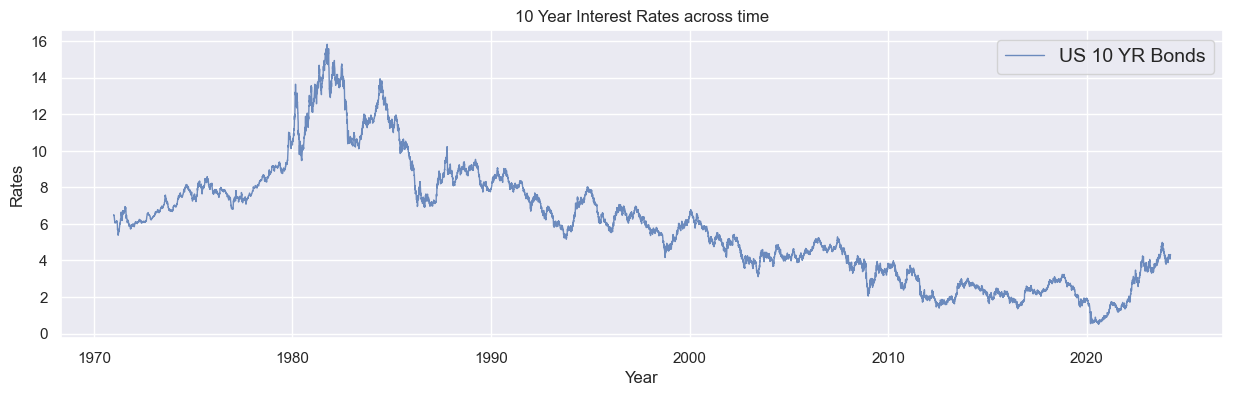

In [100]:
plt.figure(figsize=(15,4))
plt.plot(yld['Date'],yld['US 10YR Bonds'].T, lw=1, alpha=0.8,label='US 10 YR Bonds')
plt.legend(loc='upper right', fontsize=14)
plt.title('10 Year Interest Rates across time')
plt.ylabel('Rates')
plt.xlabel('Year')


### Data cleaning/processing

Over the next several steps, I will merge the datapoints in the different sheets so I can later create correlation matrices for each regime.

In [101]:
#macro['GDP YOY']
prices['year'] = prices['Date'].dt.year
prices['month'] = prices['Date'].dt.month
prices['day']=prices['Date'].dt.day
print(prices)
macro['year'] = macro['Date'].dt.year
macro['month'] = macro['Date'].dt.month
macro

            Date  S&P 500       Gold  USD Index Spot Rate  year  month  day
0     1970-12-31    92.15    37.4400              120.643  1970     12   31
1     1971-01-04    91.15    37.4615              120.530  1971      1    4
2     1971-01-05    91.80    37.4830              120.520  1971      1    5
3     1971-01-06    92.35    37.5045              120.490  1971      1    6
4     1971-01-07    92.38    37.5260              120.550  1971      1    7
...          ...      ...        ...                  ...   ...    ...  ...
13780 2024-03-13  5165.31  2174.4100              102.789  2024      3   13
13781 2024-03-14  5150.48  2162.1900              103.360  2024      3   14
13782 2024-03-15  5117.09  2155.9000              103.432  2024      3   15
13783 2024-03-18  5149.42  2160.3600              103.579  2024      3   18
13784 2024-03-19  5178.51  2157.5900              103.818  2024      3   19

[13785 rows x 7 columns]


,Date,GDP YOY,CPI YOY,regime,year,month
0,1970-12-31,-0.200000,5.6,HL,1970,12
1,1971-01-31,0.766667,5.3,HL,1971,1
2,1971-02-28,1.733333,5.0,HL,1971,2
3,1971-03-31,2.700000,4.7,HN,1971,3
4,1971-04-30,2.833333,4.2,HN,1971,4
...,...,...,...,...,...,...
634,2023-10-31,2.966667,3.2,NN,2023,10
635,2023-11-30,3.033333,3.1,NH,2023,11
636,2023-12-31,3.100000,3.4,NH,2023,12
637,2024-01-31,3.100000,3.1,NH,2024,1


In [102]:

yld['year'] = yld['Date'].dt.year
yld['month'] = yld['Date'].dt.month
yld['day'] = yld['Date'].dt.day
yld

,Date,US 10YR Bonds,year,month,day
0,1970-12-31,6.5020,1970,12,31
1,1971-01-04,6.4620,1971,1,4
2,1971-01-05,6.4720,1971,1,5
3,1971-01-06,6.4720,1971,1,6
4,1971-01-07,6.4520,1971,1,7
...,...,...,...,...,...
13631,2024-03-13,4.1899,2024,3,13
13632,2024-03-14,4.2903,2024,3,14
13633,2024-03-15,4.3063,2024,3,15
13634,2024-03-18,4.3242,2024,3,18


As mentioned previously, I am unsure of how to treat the bond yields. What I will do is try to find its price which I will use later to construct the expected returns of the portfolio. But, I only need to know the volatility and covariances of the different assets to find the minimum variance portfolio.

Using the bond yields, I will find its correlation with the different assets. 

I am predicting the bond yields to be inversely related to S&P. This is because of bonds acting as the pricing kernel which lies at the intersection of macroeconomic and finance theory. 

When the yield decreases, the risk-free rate decreases. This prompts investors to allocate more to risky assets which could generate higher returns, thus increasing the prices of S&P. And vice-versa.

In [103]:

merged_data = pd.merge(prices, macro[['year', 'month', 'regime']], on=['year', 'month'], how='left')
merged_data.tail(40)
merged_data = merged_data.dropna(subset=['regime'])

#yld_avg = yld.groupby(['year', 'month']).agg({'US 10YR Bonds': 'mean'}).reset_index()
#merged_data = pd.merge(merged_data, yld_avg, on=['year', 'month'], how='left')
merged_data = pd.merge(merged_data, yld, on=['year', 'month', 'day'], how='left')
merged_data=merged_data.drop(columns='Date_y')
merged_data=merged_data.rename(columns={'Date_x':'Date'})
#merged_data.isna().sum()
merged_data

,Date,S&P 500,Gold,USD Index Spot Rate,year,month,day,regime,US 10YR Bonds
0,1970-12-31,92.15,37.4400,120.643,1970,12,31,HL,6.5020
1,1971-01-04,91.15,37.4615,120.530,1971,1,4,HL,6.4620
2,1971-01-05,91.80,37.4830,120.520,1971,1,5,HL,6.4720
3,1971-01-06,92.35,37.5045,120.490,1971,1,6,HL,6.4720
4,1971-01-07,92.38,37.5260,120.550,1971,1,7,HL,6.4520
...,...,...,...,...,...,...,...,...,...
13767,2024-02-23,5088.80,2035.4000,103.936,2024,2,23,NH,4.2480
13768,2024-02-26,5069.53,2031.2400,103.827,2024,2,26,NH,4.2795
13769,2024-02-27,5078.18,2030.4800,103.829,2024,2,27,NH,4.3032
13770,2024-02-28,5069.76,2034.5500,103.975,2024,2,28,NH,4.2639


In [104]:


#df_cleaned = df.drop(columns=cols_to_drop)
dropcol=['Date','year','month','day','regime']


LL_p = merged_data[merged_data['regime'] == 'LL'].drop(columns=dropcol).reset_index()

LN_p = merged_data[merged_data['regime'] == 'LN'].drop(columns=dropcol).reset_index()

LH_p = merged_data[merged_data['regime'] == 'LH'].drop(columns=dropcol).reset_index()

NL_p = merged_data[merged_data['regime'] == 'NL'].drop(columns=dropcol).reset_index()

NN_p = merged_data[merged_data['regime'] == 'NN'].drop(columns=dropcol).reset_index()

NH_p = merged_data[merged_data['regime'] == 'NH'].drop(columns=dropcol).reset_index()

HL_p = merged_data[merged_data['regime'] == 'HL'].drop(columns=dropcol).reset_index()

HN_p = merged_data[merged_data['regime'] == 'HN'].drop(columns=dropcol).reset_index()

HH_p = merged_data[merged_data['regime'] == 'HH'].drop(columns=dropcol).reset_index()
returns_lst=[LL_p,LN_p,LH_p,NL_p,NN_p,NH_p,HL_p,HN_p,HH_p]

for j in range(9):
    returns_lst[j]=returns_lst[j].drop(columns='index')
#returns_lst[5]['Bond_Price'].tail(50)
returns_lst[3]
#col

,S&P 500,Gold,USD Index Spot Rate,US 10YR Bonds
0,138.72,440.25,121.030,10.7420
1,138.82,446.25,120.330,10.6820
2,138.69,441.25,119.580,10.4720
3,141.77,445.25,119.680,10.4620
4,142.72,454.50,119.360,10.4820
...,...,...,...,...
1016,3909.52,1726.93,92.848,1.6332
1017,3974.54,1732.52,92.766,1.6760
1018,3971.09,1712.20,92.944,1.7081
1019,3958.55,1685.20,93.297,1.7029


## Important note

The returns seem abit too low, I suspect it's because .pct_change() shows the return as the magnitude instead of percentage.

Also, I realized there is a huge discrepancy between the correlation matrices of using and not using pct_change(). The results from pct_change() creates results that simply doesn't make sense. And what I mean by that is I would expect bond yields to consistently be inversely related to S&P but when I take pct_change(), the r/s doesn't hold.

Now, yes we should follow the data. But I suspect, the way how I have handled the returns have been flawed which has produced flawed results for me. 

If you are curious to find out, turn the above raw chunk to code and run that code chunk as well as the code chunk below to see the difference.

The moment I have been waiting for..
Now that I have the returns for all different states and each state has atleast 1000 observations, I can now plot the correlation matrices. And I can see how I would construct the minimum variance portfolios.

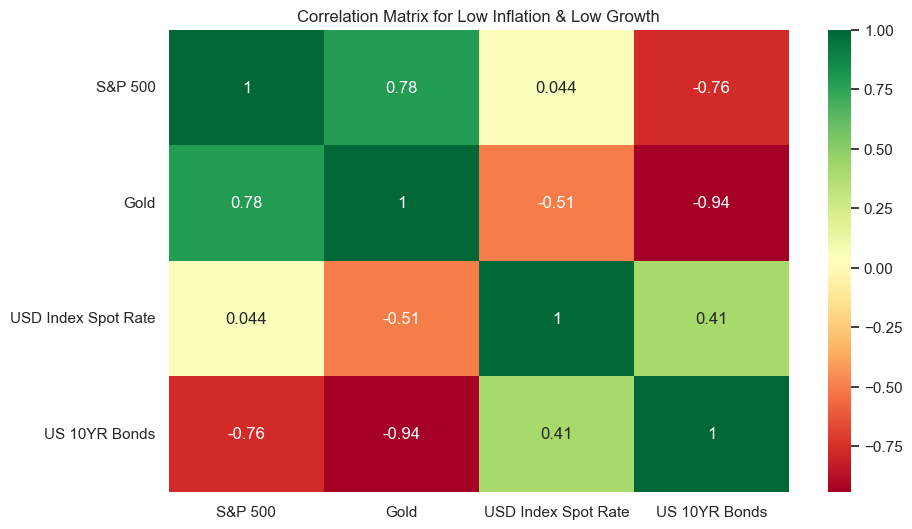

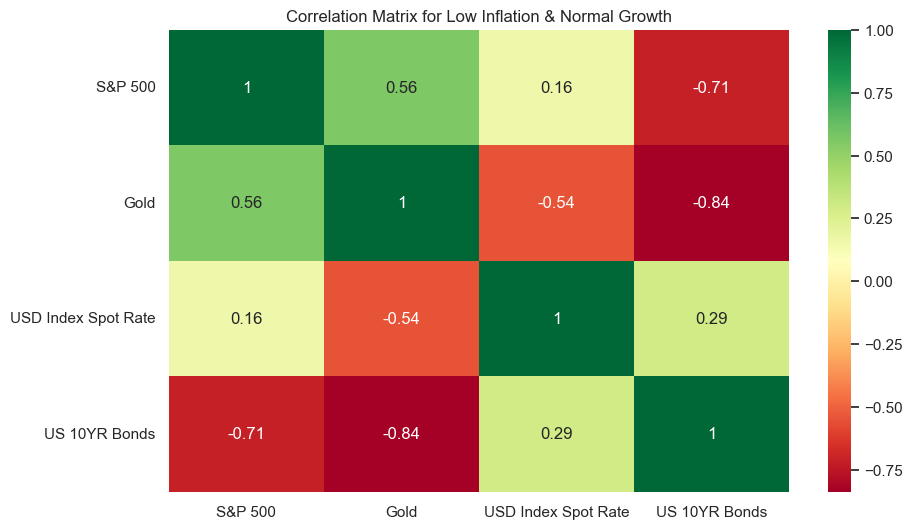

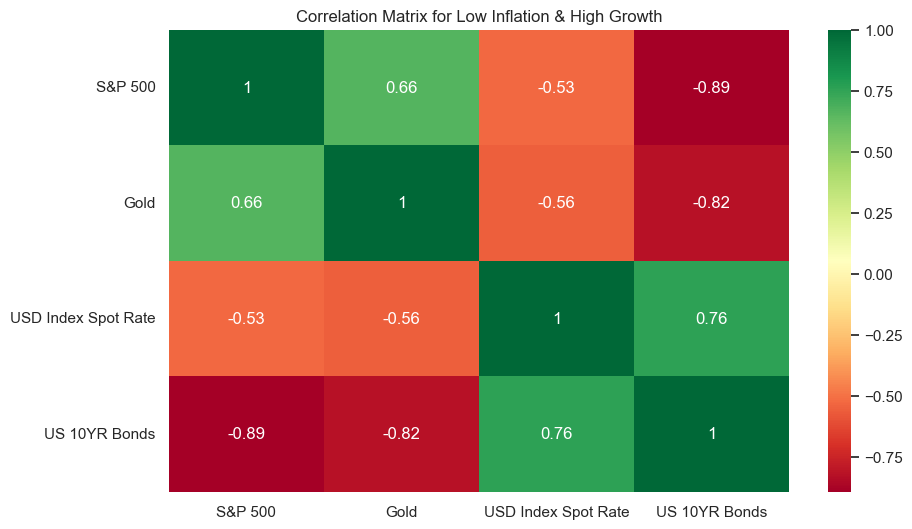

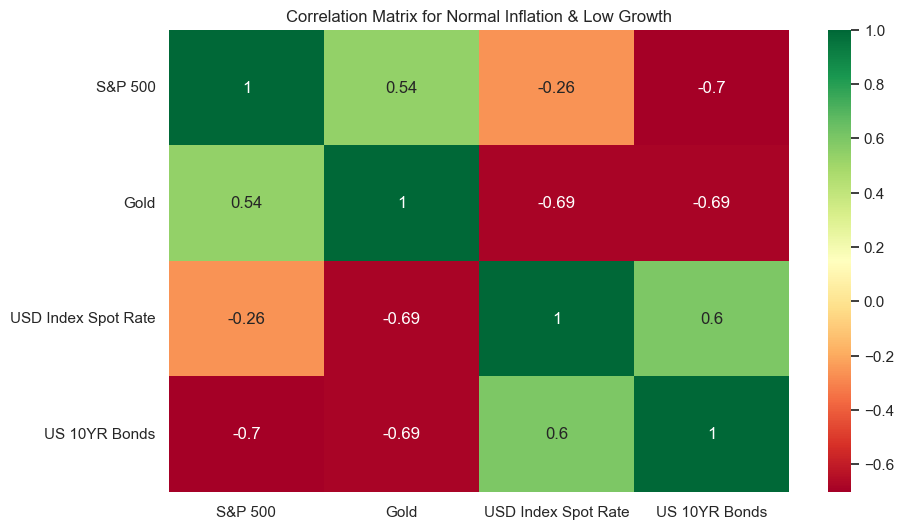

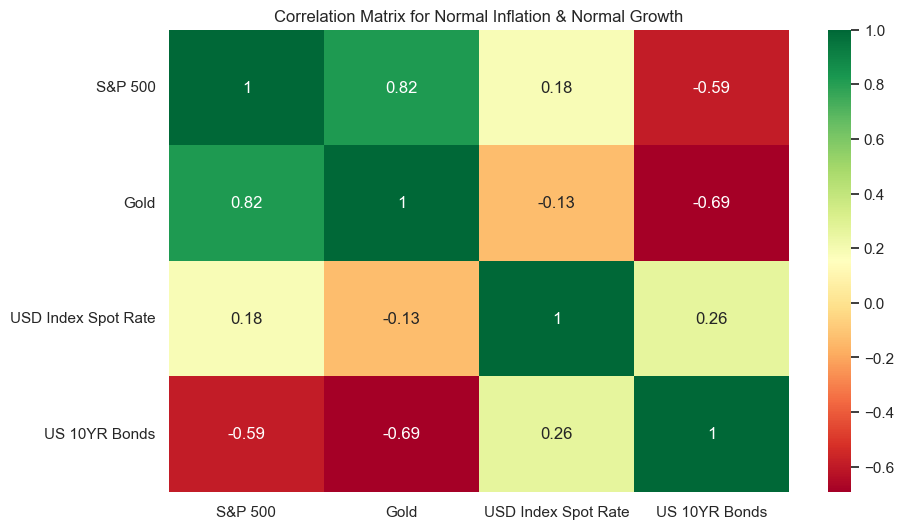

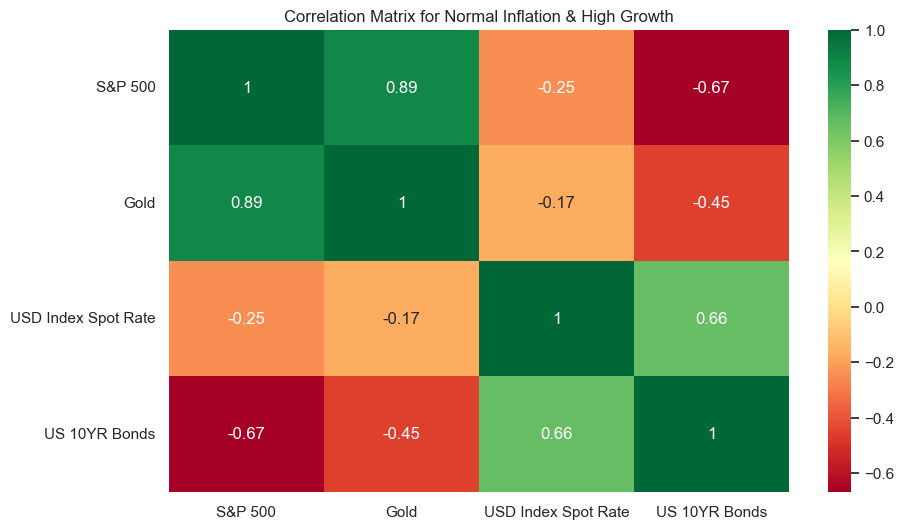

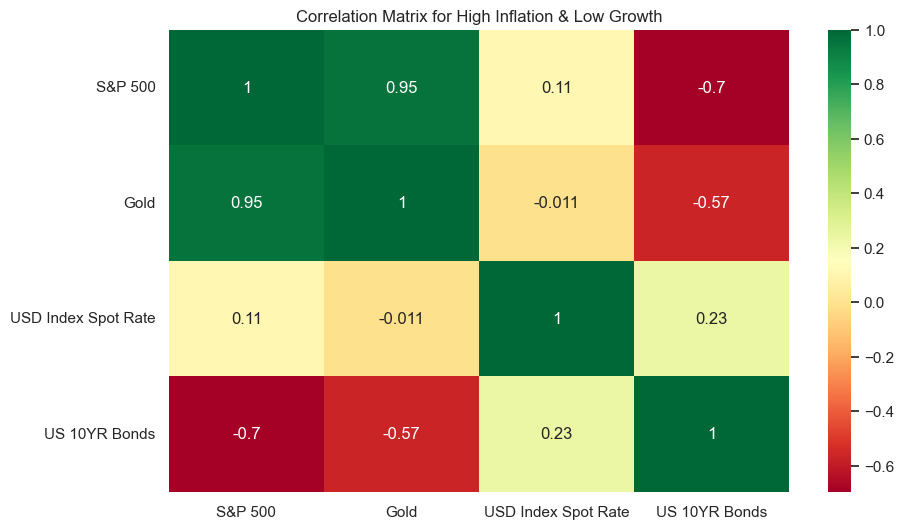

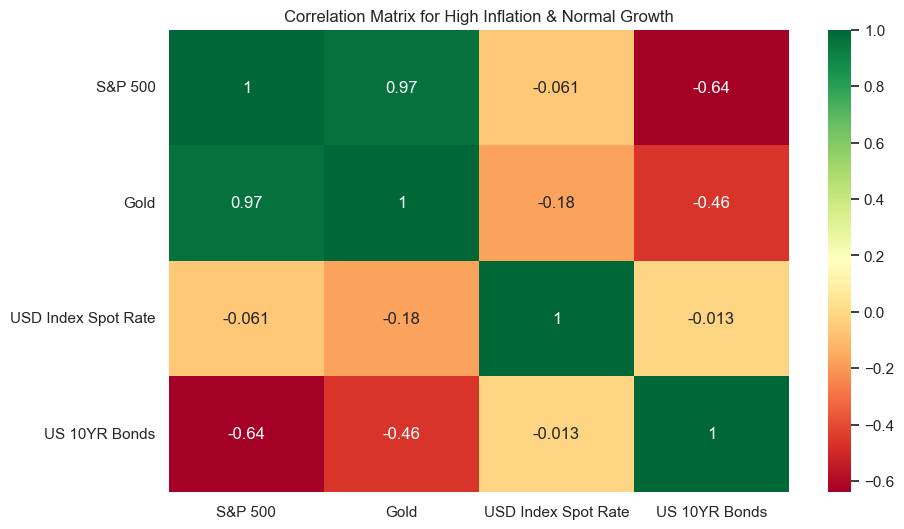

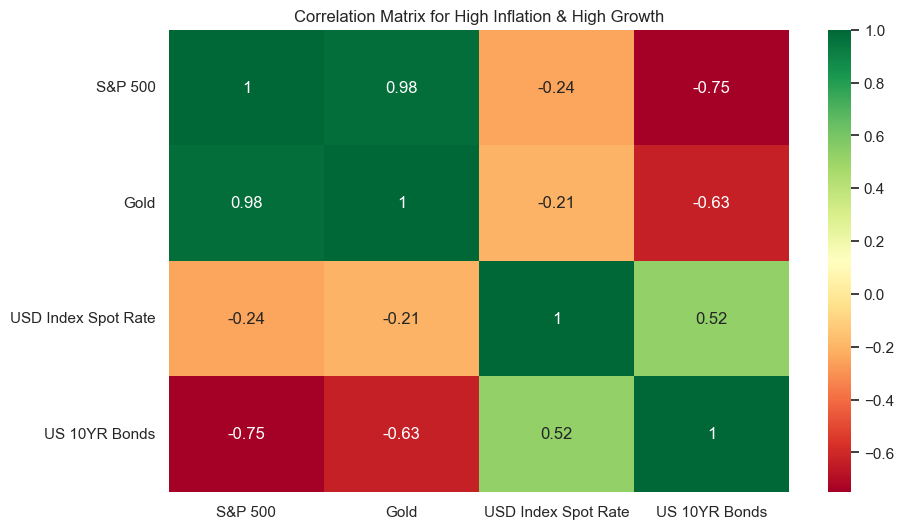

In [105]:
titles_lst=['Low Inflation & Low Growth','Low Inflation & Normal Growth','Low Inflation & High Growth','Normal Inflation & Low Growth','Normal Inflation & Normal Growth','Normal Inflation & High Growth','High Inflation & Low Growth','High Inflation & Normal Growth','High Inflation & High Growth']
for i in range(9):
    plt.figure(figsize=(10, 6))
    plt.title(f'Correlation Matrix for {titles_lst[i]}')
    sns.set(style='darkgrid')
    corr = returns_lst[i].corr()
    sns.heatmap(corr,annot=True,cmap='RdYlGn')
    #corr

## Interpretation

The above correlation matrices present interesting findings and how it ought to be interpreted depends on the investor's goals. In all regimes, as we expected, the bond yield is inversely related to S&P. For hedging, we would want the correlations to be significantly negative(less than -0.1).

In periods of low inflation, only bonds can be used to hedge S&P and in LH (low inflation & high growth), cash can also be used to hedge but it would only be advisable insofar as minimizing the variance but it will not be ideal to maximize returns since traditional wisdom calls for investing in S&P in bull markets signified by high growth. 

In NL & NH, S&P can also be hedged with cash. For NL, it would even be optimal to maximize returns with holding cash since S&P may not perform well during periods of low growth which usually signifies bear markets.

In periods of high inflation, I have to admit my results don't make sense. Traditional wisdom says to invest in commodities like gold in periods of high inflation to hedge against inflation. But my results show positive co-movement between S&P and gold regardless of growth. I honestly don't know why. And during HH, to minimize the variance of portfolio, my results suggest to increase cash holdings but I would advise against it because the last thing during high inflation is to hold more cash.

# Conclusion

Make no mistake, I failed in this task. I was busy trying to make sense of the data and in the end, did not have time to implement optimal or min variance portfolios. But that's alright. This has been an extremely informative assignment for me and I have got to learn alot more not only about Python but also about finance/macro.

Why did I fail? I suspect it has several causes. 
1. Perhaps the way how I defined economic regimes might have shown deeper relationships between the assets than what I have been expecting and was hoping to rely on to construct the portfolios.
2. The methods used for interpolation may not have been ideal. I am not sure about this because as I was going through the process, it seemed as if this was correct. But, I don't want to rule out this possibility.
3. I am extremely sure something went seriously wrong when I tried calculating the percentage change. Again, I don't know why but the inconsistent results suggest something did not go as expected.

Lastly, I want to be absolutely clear that the the data is not wrong. I believe what I needed to do is to better understand how to capture the meaning within the data. There is a narrative that is veiled within the data which I am trying to explore. But, I also believe this piece of work provides me with the foundation for future explorations and as I get more familiar with the data, I will also be able to better understand all the different interactions.

Thank you for giving me this opportunity to explore this problem. It was really fun to integrate across my exposure to macro/fin/coding. I got to learn alot through this process and it has made me alot more comfortable with coding in Python. Understanding how the variables are stored and processed definitely created alot of headaches for me but eventually debugging it helped me developed a much stronger understanding and appreciation of Python.
